In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay,auc,classification_report,roc_auc_score,roc_curve,precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import jaccard_score


In [7]:
#loading the transformed Data Set
solar_data = pd.read_csv(r"solar_data_transformed18.csv")
print(solar_data.columns)

Index(['ID', 'County', 'InstallType', 'UrbanRural', 'Class', 'Percent_100',
       'Substation_100', 'HIFLD_100', 'Percent_200', 'Substation_200',
       'HIFLD_200', 'Percent_CAISO', 'Substation_CAISO', 'HIFLD_CAISO',
       'SolarTech', 'Area', 'Length', 'DistSub_100_binned',
       'DistSub_200_binned', 'DistSub_CAISO_binned'],
      dtype='object')


In [8]:
X_scaled = solar_data.drop(columns=['ID','InstallType'])  # Features
y = solar_data['InstallType']  # Target

####  Applying the model implementation with PCA

In [9]:
#Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

In [10]:
#Split the PCA-transformed data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [11]:
#Train and tune KNN on PCA data
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 10], 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 10],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Best Parameters: {'n_neighbors': 7, 'weights': 'distance'}
Accuracy: 0.8583333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90       427
           1       0.83      0.79      0.81       287
           2       0.80      0.90      0.85       366

    accuracy                           0.86      1080
   macro avg       0.86      0.85      0.85      1080
weighted avg       0.86      0.86      0.86      1080

ROC-AUC Score: 0.9576364500409835


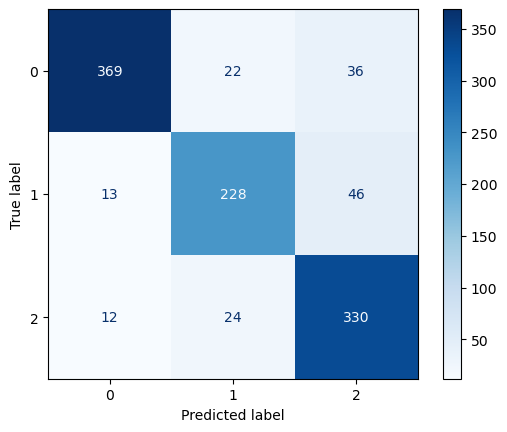

In [12]:
# Evaluate the best model
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

y_prob = best_knn.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)


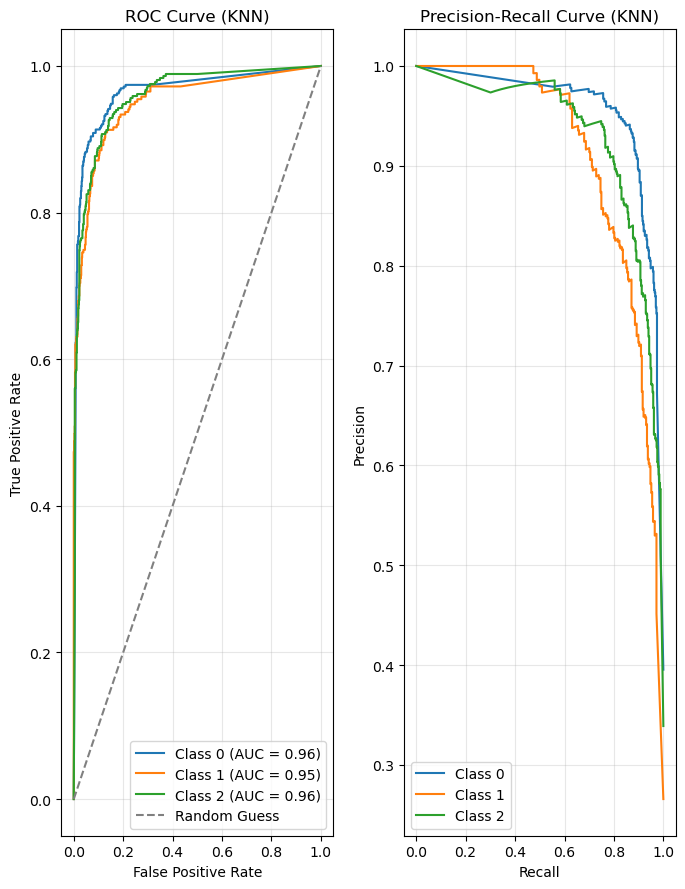

In [13]:
# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))  # Use y_train for consistent class labels
y_prob = best_knn.predict_proba(X_test)  # Predicted probabilities

# Plot ROC Curve
plt.figure(figsize=(7, 9))

# ROC Curve for each class
n_classes = len(np.unique(y_train))  # Number of classes
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("ROC Curve (KNN)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Precision-Recall Curve
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"Class {i}")

plt.subplot(1, 2, 2)
plt.title("Precision-Recall Curve (KNN)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
#Use roc_auc_score with 'ovr' or 'ovo' for multiclass
print("ROC-AUC Score (OVR):", roc_auc_score(y_test, y_prob, multi_class='ovr'))
print("ROC-AUC Score (OVO):", roc_auc_score(y_test, y_prob, multi_class='ovo'))
#print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred_dt))
from sklearn.metrics import cohen_kappa_score
kappa_score = cohen_kappa_score(y_test, y_pred)
print("Cohen's Kappa Score:", kappa_score)
print("Jaccard Score (Macro):", jaccard_score(y_test, y_pred, average='macro'))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))

ROC-AUC Score (OVR): 0.9576364500409835
ROC-AUC Score (OVO): 0.9565544363273984
Cohen's Kappa Score: 0.7850486255287928
Jaccard Score (Macro): 0.7458878363192523
Matthews Correlation Coefficient: 0.7867755503531855


#### KKN with PCA Insights

The model boasted an accuracy of 86%, but most impressively, it achieved a very high ROC-AUC score of 0.9576, which reflected great performance in terms of class separation. Class 0 performed very well, with a precision of 0.94, a recall of 0.86, and an F1-score of 0.90, but there is a little room for improvement in the area of recall. Class 2 also performed very well with a recall of 0.90 and an F1-score of 0.85, although the precision was somewhat lower at 0.80, hence some false positives. Class 1 was relatively weak, with a precision of 0.83, recall of 0.79, and F1-score of 0.81, which shows that for this model, further optimization might be required, such as dealing with class imbalance or tweaking decision thresholds. PCA helped in reducing the dimensions and gave a better focus on important features; this can be fine-tuned further. The overall macro average F1 is 0.85 and weighted average F1 is 0.86; hence, the performance is balanced though further tuning for class 1 would carry a big value.

#### Applying the model implementation without PCA

In [15]:
#loading the transformed Data Set
solar_data_v2 = pd.read_csv(r"solar_data_transformed18.csv")

In [16]:
X_v2 = solar_data_v2.drop("InstallType", axis=1)  # Features
y_v2 = solar_data_v2["InstallType"]  # Target

In [17]:
#Split the data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

In [18]:
# Convert the DataFrame to a NumPy array
X_train1 = X_train1.values  # Ensure that it's a NumPy array
X_test1 = X_test1.values

# Train the KNN model
knn1 = KNeighborsClassifier(n_neighbors=5)
knn1.fit(X_train1, y_train1)


KNeighborsClassifier()

In [19]:
y_pred1 = knn1.predict(X_test1)
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test1, y_pred1))
print("Classification Report:\n", classification_report(y_test1, y_pred1))

Accuracy: 0.725925925925926
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       427
           1       0.61      0.60      0.61       287
           2       0.71      0.68      0.70       366

    accuracy                           0.73      1080
   macro avg       0.71      0.71      0.71      1080
weighted avg       0.72      0.73      0.72      1080



In [23]:
from sklearn.metrics import roc_auc_score, cohen_kappa_score, jaccard_score, matthews_corrcoef
from sklearn.preprocessing import label_binarize

# Get the predicted probabilities for ROC-AUC calculation
y_prob = knn1.predict_proba(X_test1)

# Binarize the output labels for multiclass ROC-AUC calculation
y_test_binarized = label_binarize(y_test1, classes=[0, 1, 2])  # Adjust classes if necessary

# Calculate ROC-AUC Score (One-vs-Rest)
roc_auc_ovr = roc_auc_score(y_test_binarized, y_prob, multi_class='ovr')
print("ROC-AUC Score (OVR):", roc_auc_ovr)

# Calculate ROC-AUC Score (One-vs-One)
roc_auc_ovo = roc_auc_score(y_test_binarized, y_prob, multi_class='ovo')
print("ROC-AUC Score (OVO):", roc_auc_ovo)

# Cohen's Kappa Score
kappa_score = cohen_kappa_score(y_test1, y_pred1)
print("Cohen's Kappa Score:", kappa_score)

# Jaccard Score (Macro)
jaccard_macro = jaccard_score(y_test1, y_pred1, average='macro')
print("Jaccard Score (Macro):", jaccard_macro)

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test1, y_pred1)
print("Matthews Correlation Coefficient:", mcc)


ROC-AUC Score (OVR): 0.8530154740340787
ROC-AUC Score (OVO): 0.8530154740340787
Cohen's Kappa Score: 0.5828439892892375
Jaccard Score (Macro): 0.5588047405962592
Matthews Correlation Coefficient: 0.5830492969526277


#### KNN without PCA insights

Overall, the KNN model without PCA yielded an overall accuracy of 72.6%. However, the performances between the three classes
are rather far between. Class 0 turned in the best performance with equally impressive precision of 0.81, recall of 0.85, and F1-score of 0.83, all pointers to a very strong predictive power. 
However, for Class 1, the model performances decline to a low of about 0.60 for both precision and recall, hence indicating difficulty in correctly identifying this class. Class 2 is the average, with reasonable metrics: precision 0.71, recall 0.68, F1-score 0.70. 
The macro and weighted averages are 0.71, indicating a balanced enough performance, though the class imbalance may affect the model's ability to distinguish classes effectively.